<a href="https://colab.research.google.com/github/KeiandraK/DS-Unit-2-Linear-Models/blob/master/Keiandra_King_3_assignment_regression_classification_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

Instead, predict property sales prices for **One Family Dwellings** (`BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'`). 

Use a subset of the data where the **sale price was more than \\$100 thousand and less than $2 million.** 

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.

- [X] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [X] Do one-hot encoding of categorical features.
- [X] Do feature selection with `SelectKBest`.
- [X] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [X] Fit a ridge regression model with multiple features.
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.


## Stretch Goals
- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [0]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [0]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

In [0]:
# Setting the mask(labeled as one_fam)
one_fam= ((df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS') &
(df['SALE_PRICE']>100000) & (df['SALE_PRICE']<200000000))

df_fam= df[one_fam]

In [0]:
df_fam.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,NaN,A9,4832 BAY PARKWAY,NaN,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,01/01/2019
61,4,OTHER,01 ONE FAMILY DWELLINGS,1,7918,72,NaN,A1,80-23 232ND STREET,NaN,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,1,A1,200000,01/01/2019
78,2,OTHER,01 ONE FAMILY DWELLINGS,1,4210,19,NaN,A1,1260 RHINELANDER AVE,NaN,10461.0,1.0,0.0,1.0,"3,500",2043.0,1925.0,1,A1,810000,01/02/2019
108,3,OTHER,01 ONE FAMILY DWELLINGS,1,5212,69,NaN,A1,469 E 25TH ST,NaN,11226.0,1.0,0.0,1.0,"4,000",2680.0,1899.0,1,A1,125000,01/02/2019
111,3,OTHER,01 ONE FAMILY DWELLINGS,1,7930,121,NaN,A5,5521 WHITTY LANE,NaN,11203.0,1.0,0.0,1.0,"1,710",1872.0,1940.0,1,A5,620000,01/02/2019


In [0]:
df_fam.shape

(3232, 21)

In [0]:
df_fam['SALE_DATE']=pd.to_datetime(df_fam['SALE_DATE'],infer_datetime_format=True)
cutoff=pd.to_datetime('2019-04-01')
train= df_fam[df_fam.SALE_DATE < cutoff]
test= df_fam[df_fam.SALE_DATE.dt.month==4]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
train.dtypes

BOROUGH                                   object
NEIGHBORHOOD                              object
BUILDING_CLASS_CATEGORY                   object
TAX_CLASS_AT_PRESENT                      object
BLOCK                                      int64
LOT                                        int64
EASE-MENT                                float64
BUILDING_CLASS_AT_PRESENT                 object
ADDRESS                                   object
APARTMENT_NUMBER                          object
ZIP_CODE                                 float64
RESIDENTIAL_UNITS                        float64
COMMERCIAL_UNITS                         float64
TOTAL_UNITS                              float64
LAND_SQUARE_FEET                          object
GROSS_SQUARE_FEET                        float64
YEAR_BUILT                               float64
TAX_CLASS_AT_TIME_OF_SALE                  int64
BUILDING_CLASS_AT_TIME_OF_SALE            object
SALE_PRICE                                 int64
SALE_DATE           

In [0]:
train.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,NaN,A9,4832 BAY PARKWAY,NaN,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,2019-01-01
61,4,OTHER,01 ONE FAMILY DWELLINGS,1,7918,72,NaN,A1,80-23 232ND STREET,NaN,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,1,A1,200000,2019-01-01
78,2,OTHER,01 ONE FAMILY DWELLINGS,1,4210,19,NaN,A1,1260 RHINELANDER AVE,NaN,10461.0,1.0,0.0,1.0,"3,500",2043.0,1925.0,1,A1,810000,2019-01-02
108,3,OTHER,01 ONE FAMILY DWELLINGS,1,5212,69,NaN,A1,469 E 25TH ST,NaN,11226.0,1.0,0.0,1.0,"4,000",2680.0,1899.0,1,A1,125000,2019-01-02
111,3,OTHER,01 ONE FAMILY DWELLINGS,1,7930,121,NaN,A5,5521 WHITTY LANE,NaN,11203.0,1.0,0.0,1.0,"1,710",1872.0,1940.0,1,A5,620000,2019-01-02


In [0]:
print(train['SALE_DATE'].dt.month.unique())

[1 2 3]


In [0]:
print(test['SALE_DATE'].dt.month.unique())

[4]


In [0]:
df_fam.select_dtypes(exclude='number').columns

Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY',
       'TAX_CLASS_AT_PRESENT', 'BUILDING_CLASS_AT_PRESENT', 'ADDRESS',
       'APARTMENT_NUMBER', 'LAND_SQUARE_FEET',
       'BUILDING_CLASS_AT_TIME_OF_SALE', 'SALE_DATE'],
      dtype='object')

In [0]:
from sklearn.preprocessing import OneHotEncoder
onehotencoder= OneHotEncoder(categorical_features=[0])

In [0]:
import category_encoders as ce

encoder = ce.OneHotEncoder(use_cat_names=True)

In [0]:
# Subset and split again
target='SALE_PRICE'
number_column = train.select_dtypes(include='number').columns.drop(target).tolist()
categorical_column = train.select_dtypes(exclude='number').columns.tolist()
low_cardinality_catg = [col for col in categorical_column
                               if train[col].nunique() <= 50]

features=number_column + low_cardinality_catg

X_train= train[features]
y_train= train[target]
X_test=test[features]
y_test=test[target]

In [0]:
# Checking shape to verify 
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2576, 17)
(2576,)
(656, 17)
(656,)


In [0]:
df_fam['NEIGHBORHOOD'].value_counts()

OTHER                      3026
FLUSHING-NORTH               97
EAST NEW YORK                31
FOREST HILLS                 26
BOROUGH PARK                 19
ASTORIA                      14
BEDFORD STUYVESANT           10
UPPER EAST SIDE (59-79)       7
UPPER EAST SIDE (79-96)       2
Name: NEIGHBORHOOD, dtype: int64

In [0]:
df_fam['LAND_SQUARE_FEET'].unique().shape

(1075,)

# One Hot Encoding

In [0]:
# Encoding 
import category_encoders as ce
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train = encoder.fit_transform(X_train)
X_test= encoder.transform(X_test)

In [0]:
X_train.drop(['EASE-MENT','APARTMENT_NUMBER_nan'],inplace=True,axis=1)

In [0]:
X_test.drop(['EASE-MENT','APARTMENT_NUMBER_nan'],inplace=True,axis=1)

In [0]:
from sklearn.feature_selection import f_regression, SelectKBest
selector= SelectKBest(score_func=f_regression,k=10)

X_train_selected= pd.DataFrame(selector.fit_transform(X_train,y_train), columns=X_train.columns[selector.get_support()])
X_test_selected= pd.DataFrame(selector.transform(X_test), columns=X_test.columns[selector.get_support()])

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [0]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(True, True)

# Feature Scaling

In [0]:
# Feature Scaling 
X_train_scaler= pd.DataFrame(scaler.fit_transform(X_train_selected,y_train), columns=X_train_selected.columns)
X_test_scaler= pd.DataFrame(scaler.transform(X_test_selected), columns=X_test_selected.columns)

In [0]:
import warnings
warnings.filterwarnings(action='ignore', category=RuntimeWarning, module='sklearn')

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
for k in range(1, len(X_train.columns)+1):
    print(f'{k} features')
    
    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
    
    model = LinearRegression()
    model.fit(X_train_selected, y_train)
    
    y_pred = model.predict(X_test_selected)
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Test MAE: ${mae:,.0f} \n')


1 features
Test MAE: $290,855 

2 features
Test MAE: $288,471 

3 features
Test MAE: $255,484 

4 features
Test MAE: $260,289 

5 features
Test MAE: $258,212 

6 features
Test MAE: $258,212 

7 features
Test MAE: $253,793 

8 features
Test MAE: $241,563 

9 features
Test MAE: $244,664 

10 features
Test MAE: $242,496 

11 features
Test MAE: $243,042 

12 features
Test MAE: $243,669 

13 features


/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-

Test MAE: $240,242 

14 features
Test MAE: $241,032 

15 features
Test MAE: $241,184 

16 features
Test MAE: $241,051 

17 features
Test MAE: $239,593 

18 features
Test MAE: $239,593 

19 features
Test MAE: $240,136 

20 features
Test MAE: $240,139 

21 features
Test MAE: $242,432 

22 features
Test MAE: $242,413 

23 features


/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-

Test MAE: $242,402 

24 features
Test MAE: $243,047 

25 features
Test MAE: $235,757 

26 features
Test MAE: $235,757 

27 features
Test MAE: $236,007 

28 features
Test MAE: $236,008 

29 features
Test MAE: $235,459 

30 features
Test MAE: $235,041 

31 features
Test MAE: $234,637 

32 features
Test MAE: $234,835 

33 features
Test MAE: $234,713 

34 features
Test MAE: $234,645 

35 features
Test MAE: $234,601 

36 features
Test MAE: $234,734 

37 features
Test MAE: $234,734 

38 features


/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-

Test MAE: $234,819 

39 features
Test MAE: $234,838 

40 features
Test MAE: $235,284 

41 features
Test MAE: $231,756 

42 features
Test MAE: $232,571 

43 features
Test MAE: $230,122 

44 features
Test MAE: $230,006 

45 features
Test MAE: $229,999 

46 features
Test MAE: $228,874 

47 features
Test MAE: $228,874 

48 features
Test MAE: $228,902 

49 features
Test MAE: $228,924 

50 features


/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-

Test MAE: $228,924 

51 features
Test MAE: $228,942 

52 features
Test MAE: $229,256 

53 features
Test MAE: $229,256 

54 features
Test MAE: $229,256 



/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-

# Ridge Regression

In [0]:
# Ridge Regression
from sklearn.linear_model import RidgeCV
import matplotlib.pyplot as plt

In [0]:
from sklearn.feature_selection import f_regression, SelectKBest

for k in range(1, len(X_train_selected.columns)+1):
  print(f'{k} features')


  Selector= SelectKBest(score_func=f_regression,k='k')
  X_train_selected_R = selector.fit_transform(X_train_scaler, y_train)
  X_test_selected_R = selector.transform(X_test_scaler)


  ridge= RidgeCV()
  ridge.fit(X_train_selected_R,y_train)

  y_ridge_pred= ridge.predict(X_test_selected_R)
  mae= mean_absolute_error(y_test,y_ridge_pred)


  print(f'Test MAE: ${mae:,.0f} \n')

1 features
Test MAE: $242,494 

2 features
Test MAE: $242,494 

3 features
Test MAE: $242,494 

4 features
Test MAE: $242,494 

5 features
Test MAE: $242,494 

6 features
Test MAE: $242,494 

7 features
Test MAE: $242,494 

8 features
Test MAE: $242,494 

9 features
Test MAE: $242,494 

10 features
Test MAE: $242,494 



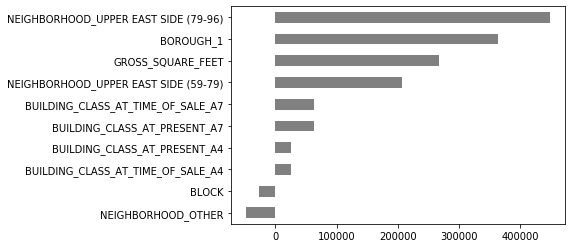

In [0]:
%matplotlib inline
coefficients = pd.Series(ridge.coef_, X_train_selected.columns)
coefficients.sort_values().plot.barh(color='grey');

In [0]:
print(coefficients.to_string())

BLOCK                                   -27455.019497
GROSS_SQUARE_FEET                       267405.892196
BOROUGH_1                               363386.517745
NEIGHBORHOOD_OTHER                      -48285.703754
NEIGHBORHOOD_UPPER EAST SIDE (59-79)    206985.873039
NEIGHBORHOOD_UPPER EAST SIDE (79-96)    448891.194439
BUILDING_CLASS_AT_PRESENT_A7             63930.618292
BUILDING_CLASS_AT_PRESENT_A4             25841.136807
BUILDING_CLASS_AT_TIME_OF_SALE_A7        63930.618292
BUILDING_CLASS_AT_TIME_OF_SALE_A4        25841.136806
